In [223]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy.stats import beta, bernoulli
import warnings
from sklearn.linear_model import LogisticRegression, LinearRegression

In [224]:
B = 400
alpha = 0.05
seed = 212778229
np.random.seed(seed=seed)
warnings.filterwarnings('ignore')

# Part A - Bayesian 

As in Project 2, we will define $X$ to be 'pH' and $Y$ to be the color of the wine.

## Question 1:

In [225]:
# Load dataset
red_wine_df = pd.read_csv("/data/workspace_files/Dataset/winequality-red.csv", sep=';')
red_wine_df.insert(2, "color", 0, True)
white_wine_df = pd.read_csv("/data/workspace_files/Dataset/winequality-white.csv", sep=';')
white_wine_df.insert(2, "color", 1, True)

total_wine_df = pd.concat([red_wine_df, white_wine_df], ignore_index=True)
# Randomly sample 200 instances
samples = total_wine_df.sample(200, ignore_index=True, random_state=seed)[['volatile acidity', 'free sulfur dioxide',\
'quality', 'pH', 'color']]
filtered = pd.concat([total_wine_df,samples]).drop_duplicates(keep=False)
past_samples = filtered.sample(1000, ignore_index=True, random_state=seed)

## Question 2:

### (a)

In [226]:
tau = samples.pH.median()

In [227]:
def log_odds_estim(sample_data):
    # Split into categories
    reds = sample_data[sample_data.color == 0].pH
    whites = sample_data[sample_data.color == 1].pH
    # Calculate probabilities
    p1 = reds[reds > tau].count() / reds.shape[0]
    p2 = whites[whites <= tau].count() / whites.shape[0]
    # Calculate log-odds for each category
    log_odds_1 = np.log(p1 / (1 - p1))
    log_odds_2 = np.log(p2 / (1 - p2))

    psi = log_odds_1 - log_odds_2
    return psi

In [228]:
sample_psi = log_odds_estim(samples)

psis = np.zeros(B)

# Calculate quantile-based confidence interval
for i in range(B):
    boot_samples = samples.sample(200, ignore_index=True, replace=True, random_state=seed+i)[['pH', 'color']]
    psis[i] = log_odds_estim(boot_samples)

low = np.quantile(psis, 0.025, axis=0)
high = np.quantile(psis, 0.975, axis=0)

print(f"Original sample psi: {sample_psi}")

print(f"Psi confidence interval: {[low, high]}")

Original sample psi: 0.6843674929078997
Psi confidence interval: [-0.04264356627739888, 1.337607207331962]


### (b)

array([[%lt;AxesSubplot:title={'center':'0'}%gt;]], dtype=object)

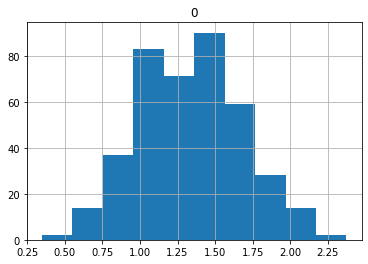

In [229]:
# Split into categories
reds = samples[samples.color == 0].pH
whites = samples[samples.color == 1].pH

n1 = reds.shape[0]
n2 = whites.shape[0]

s1 = reds[reds > tau].shape[0]
s2 = whites[whites > tau].shape[0]

p1_arr = np.random.beta(a=s1+1, b=n1-s1+1, size=B)
p2_arr = np.random.beta(a=s2+1, b=n2-s2+1, size=B)

eta_1s = np.log(p1_arr / (1 - p1_arr))
eta_2s = np.log(p2_arr / (1 - p2_arr))

psis = eta_1s - eta_2s
# psi_hat = np.histogram(psis).max()

psi_df = pd.DataFrame(psis)
# Plot histogram of psi values as calculated in Example 11.4 in the book
psi_df.hist()

As we can see, the maximum of the estimated posterior distribution occurs when $\widehat\psi \approx 1.25$.

In [230]:
# Calculate credible interval based on quantiles of the estimated psis
low = np.quantile(psis, 0.025, axis=0)
high = np.quantile(psis, 0.975, axis=0)

print(f"Credible interval for psi: {[low, high]}")

Credible interval for psi: [0.6458465956334876, 2.0340829310908033]


### (c)

array([[%lt;AxesSubplot:title={'center':'0'}%gt;]], dtype=object)

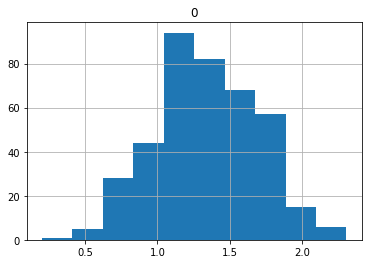

In [231]:
jeff_priors_1 = np.random.beta(a=s1+0.5, b=n1-s1+0.5, size=B)
jeff_priors_2 = np.random.beta(a=s2+0.5, b=n2-s2+0.5, size=B)

eta_1s = np.log(jeff_priors_1 / (1 - jeff_priors_1))
eta_2s = np.log(jeff_priors_2 / (1 - jeff_priors_2))

psis = eta_1s - eta_2s
# psi_hat = np.histogram(psis).max()

psi_df = pd.DataFrame(psis)
# Plot histogram of psi values as calculated in Example 11.4 in the book
psi_df.hist()

As we can see, the maximum of the estimated posterior distribution occurs when $\widehat\psi \approx 1.25$.

In [232]:
# Calculate credible interval based on quantiles of the estimated psis
low = np.quantile(psis, 0.025, axis=0)
high = np.quantile(psis, 0.975, axis=0)

print(f"Credible interval for psi: {[low, high]}")

Credible interval for psi: [0.6907958778249453, 2.025643720137554]


### (d)

In [233]:
red_np = past_samples[past_samples.color == 0].pH.to_numpy()
z1_s = np.array(red_np > tau).astype(float)
n1 = red_np.shape[0]
s1 = z1_s.sum()

white_np = past_samples[past_samples.color == 1].pH.to_numpy()
z2_s = np.array(white_np > tau).astype(float)
n2 = white_np.shape[0]
s2 = z2_s.sum()

alpha_1, beta_1, _, _ = beta.fit(z1_s)
alpha_2, beta_2, _, _ = beta.fit(z2_s)

print(f"p1 is ditributed Beta({alpha_1},{beta_1})")
print(f"p2 is ditributed Beta({alpha_2},{beta_2})")

p1 is ditributed Beta(1.1690613080818638e-06,7.90649604048157e-08)
p2 is ditributed Beta(1.643672398339603,0.8295042526485639)


array([[%lt;AxesSubplot:title={'center':'0'}%gt;]], dtype=object)

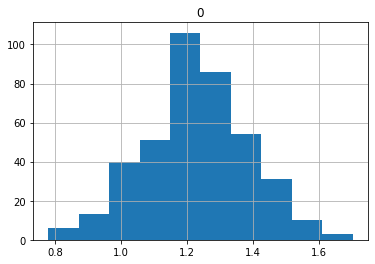

In [234]:
priors_1 = np.random.beta(a=s1+alpha_1, b=n1+beta_1-s1, size=B)
priors_2 = np.random.beta(a=s2+alpha_2, b=n2+beta_2-s2, size=B)

eta_1s = np.log(priors_1 / (1 - priors_1))
eta_2s = np.log(priors_2 / (1 - priors_2))

psis = eta_1s - eta_2s
# psi_hat = np.histogram(psis).max()

psi_df = pd.DataFrame(psis)

# Plot histogram of psi values as calculated in Example 11.4 in the book
psi_df.hist()

As we can see, the maximum of the estimated posterior distribution occurs when $\widehat\psi \approx 1.2$.

In [235]:
# Calculate credible interval based on quantiles of the estimated psis
low = np.quantile(psis, 0.025, axis=0)
high = np.quantile(psis, 0.975, axis=0)

print(f"Credible interval for psi: {[low, high]}")

Credible interval for psi: [0.9136324699559017, 1.5314196382956722]


### (e)

As we can see, all three estimators are practically the same.

# Part B - Missing Data

## Question 1:

Explanatory variables:
- volatile acidity
- citric acid
- quality


Response variable:
- pH

In [236]:
explanatory_vars = ['volatile acidity', 'free sulfur dioxide','quality']
explained_var = 'pH'

In [237]:
full_information_samples = total_wine_df.sample(1000, replace=False, ignore_index=True, random_state=seed+1)[[*explanatory_vars, 'pH', 'color']]
full_information_samples.insert(0, 'Intercept', 1)

In [238]:
explanatory_vars.insert(0, 'Intercept')

## Question 2:

In [239]:
def fit_regression(data, concat=False):
    X_np = data[explanatory_vars].to_numpy()
    if concat:
        X = np.concatenate([np.ones((data.shape[0], 1)), X_np], axis=1)
    else:
        X = X_np
    Y = data['pH'].to_numpy()
    C = np.linalg.inv(X.T @ X)
    beta_hat = C @ X.T @ Y

    y_bar = Y.mean()
    y_hat = X @ beta_hat
    SST = ((Y - y_bar) ** 2).sum()
    SSR = ((y_hat - y_bar) ** 2).sum()
    SSRes = SST - SSR
    # Three explanatory variables and 1000 samples
    p = 4
    n = data.shape[0]
    k = 3

    MSRes = SSRes / (n - p)
    cis = np.zeros((4, 2))

    for i in range(4):
        ci_step = 2 * np.sqrt(C[i,i] * MSRes)
        l = beta_hat[i] - ci_step
        u = beta_hat[i] + ci_step
        cis[i, 0], cis[i, 1] = l, u

    return beta_hat, cis

In [240]:
beta_est, full_information_cis = fit_regression(full_information_samples)
print(f"Beta fitted on full information samples: {beta_est}")
for i, col in enumerate(['Intercept', 'volatile acidity', 'free sulfur dioxide','quality']):
    print(f"Confidence interval for {col}: {full_information_cis[i]}")

Beta fitted on full information samples: [ 3.04406156e+00  2.44386460e-01 -6.45484308e-04  1.79431664e-02]
Confidence interval for Intercept: [2.96453762 3.1235855 ]
Confidence interval for volatile acidity: [0.18376203 0.30501089]
Confidence interval for free sulfur dioxide: [-1.24322572e-03 -4.77428944e-05]
Confidence interval for quality: [0.0067012  0.02918513]


## Question 3:

In [241]:
probs = np.arange(0.2, 0.8, 0.6/999)

mask = np.ones(1000)

for i in range(1000):
    mask[i] = bernoulli.rvs(1-probs[i], random_state=seed+i)

full_samples = full_information_samples[mask == 1]
missing_samples = full_information_samples[mask == 0]

## Question 4:

### (a)

In [242]:
non_missing_beta, non_missing_cis = fit_regression(full_samples)
print(f"Beta fitted on full information samples: {non_missing_beta}")
for i, col in enumerate(['Intercept', 'volatile acidity', 'free sulfur dioxide','quality']):
    print(f"Confidence interval for {col}: {non_missing_cis[i]}")

Beta fitted on full information samples: [ 2.99099383e+00  2.45923159e-01 -6.34093531e-04  2.70666078e-02]
Confidence interval for Intercept: [2.87615661 3.10583105]
Confidence interval for volatile acidity: [0.16275345 0.32909287]
Confidence interval for free sulfur dioxide: [-0.00144861  0.00018042]
Confidence interval for quality: [0.01083367 0.04329955]


### (b)

In [243]:
aux_vars = explanatory_vars
num_full = full_samples.shape[0]
num_missing = missing_samples.shape[0]

In [244]:
# Construct matrix where each row is (1, W_i)
X = full_samples[aux_vars].to_numpy()
Y = full_samples.pH.to_numpy()

lefts = sum([np.outer(row.T, row) for row in X])
left = np.linalg.inv(lefts)

right = sum([(pH * row) for pH, row in zip(Y, X)])
# Estimate beta according to full information samples
imputed_beta = left @ right

In [245]:
# Infer missing data using estimation regression parameters
X_missing = missing_samples[aux_vars].to_numpy()
Y_missing = X_missing @ imputed_beta 

missing_samples['pH'] = Y_missing

new_full_df = pd.concat((full_samples, missing_samples))

beta_hat, imputation_cis = fit_regression(new_full_df)

In [246]:
print(f"Beta fitted on full information samples: {beta_hat}")
for i, col in enumerate(['Intercept', 'volatile acidity', 'free sulfur dioxide','quality']):
    print(f"Confidence interval for {col}: {imputation_cis[i]}")

Beta fitted on full information samples: [ 2.99099383e+00  2.45923159e-01 -6.34093531e-04  2.70666078e-02]
Confidence interval for Intercept: [2.93590828 3.04607938]
Confidence interval for volatile acidity: [0.20392914 0.28791718]
Confidence interval for free sulfur dioxide: [-0.00104814 -0.00022004]
Confidence interval for quality: [0.0192794  0.03485382]


The results are exactly the same as in the previous subsection, since the inferred values were based solely on the regression parameters fitted on the data from the previous subsection and so do not affect the parameters.

### (c)

In [247]:
M = 1000

In [248]:
def get_se(data):
    beta_hat, _ = fit_regression(data)
    n = data.shape[0]
    p = 4
    # X_np = np.concatenate((np.ones((n, 1)), data[aux_vars].to_numpy()), axis=1)
    X_np = data[aux_vars].to_numpy()
    y_np = data['pH'].to_numpy()

    C = np.diag(np.linalg.inv(X_np.T @ X_np))

    SS_res = np.sum((X_np @ beta_hat - y_np)**2)

    se_beta_hat = np.sqrt(C) * ((SS_res / (n-p)) ** 0.5)
    return se_beta_hat

In [249]:
noise_var = ((Y - (X @ beta_hat)) ** 2).mean()

betas = np.zeros((M, 4))
y_sets = np.zeros((full_information_samples.shape[0], M))
temp = full_information_samples

sample_ses = [] 

# X_all = np.concatenate((np.ones((full_information_samples.shape[0], 1)), full_information_samples[aux_vars].to_numpy()), axis=1)
X_all =  full_information_samples[aux_vars].to_numpy()

for i in range(full_information_samples.shape[0]):
    mu = (X_all[i] @ beta_hat).sum() 
    y_sets[i] = np.random.normal(loc=mu, scale=np.sqrt(noise_var), size=full_information_samples.shape[0])

for i in range(M):
    temp['pH'] = y_sets
    betas[i], _ = fit_regression(temp)
    sample_ses.append(get_se(temp))

sample_ses = np.array(sample_ses)


mult_imputation_beta = betas.mean(axis=0)
mult_imputation_beta

array([ 2.94734257e+00, 2.92938182e-01, -5.66593867e-04, 3.14225957e-02])

### (d)

In [250]:
diff = betas - mult_imputation_beta
vars_mat = sample_ses.mean(axis = 0) + (M+1)/(M*(M-1))* np.sum(diff**2, axis = 0)
ses_mat = np.sqrt(vars_mat)
ses_mat

array([0.19740457, 0.17235826, 0.01711453, 0.07422144])

In [251]:
print(f"beta calculated by Rubin's formula: {beta_est}")
for i, col in enumerate(['Intercept', 'volatile acidity', 'free sulfur dioxide','quality']):
    low = mult_imputation_beta[i] - 2*ses_mat[i]
    high = mult_imputation_beta[i] + 2*ses_mat[i]
    print(f"Confidence interval for {col}: {[low, high]}")

beta calculated by Rubin's formula: [ 3.04406156e+00  2.44386460e-01 -6.45484308e-04  1.79431664e-02]
Confidence interval for Intercept: [2.5525334379811824, 3.3421516983647175]
Confidence interval for volatile acidity: [-0.05177833696661144, 0.6376547016776564]
Confidence interval for free sulfur dioxide: [-0.034795649560156704, 0.03366246182695167]
Confidence interval for quality: [-0.11702028414483008, 0.17986547555410187]


### (e)

In [252]:
rs = np.ones(full_information_samples.shape[0])

full_samples.insert(loc=full_samples.shape[1], column='R', value=1)
missing_samples.insert(loc=missing_samples.shape[1], column='R', value=0)

total = pd.concat([full_samples, missing_samples])

In [253]:
logistic_model = LogisticRegression().fit(total[aux_vars], total['R'])
logistic_model.predict_proba(total[aux_vars])[:, 1]

array([0.48350149, 0.47634021, 0.50863792, 0.48086134, 0.52602339,
 0.47459932, 0.4799643 , 0.43778077, 0.47804185, 0.50648271,
 0.4887525 , 0.48192176, 0.51376148, 0.47156856, 0.465011 ,
 0.50828187, 0.50470329, 0.52067899, 0.54275891, 0.47058172,
 0.45996787, 0.49495359, 0.54156463, 0.48294521, 0.49747066,
 0.51436647, 0.52697894, 0.48864363, 0.51654872, 0.46574503,
 0.48824515, 0.46184489, 0.5283185 , 0.52333725, 0.50790582,
 0.45418422, 0.48907667, 0.47233835, 0.46988382, 0.53857892,
 0.44656225, 0.47589072, 0.4947383 , 0.5283185 , 0.46452824,
 0.52124617, 0.51220093, 0.49180819, 0.51236167, 0.47316257,
 0.48375371, 0.50484411, 0.49779761, 0.49375091, 0.51658587,
 0.49322601, 0.47569578, 0.50695043, 0.46984676, 0.51106518,
 0.48993752, 0.50052749, 0.44233551, 0.44761226, 0.48502976,
 0.50398032, 0.49132062, 0.53612729, 0.46588793, 0.52527043,
 0.4338175 , 0.48066623, 0.52937958, 0.5514382 , 0.45816583,
 0.46243558, 0.50955004, 0.44180313, 0.44139543, 0.49693113,
 0.46132824, 0.53673542, 0.47031552, 0.47043874, 0.4927583 ,
 0.48470573, 0.50244468, 0.49799564, 0.54754141, 0.50532323,
 0.47395248, 0.49018728, 0.47759484, 0.55690087, 0.48226292,
 0.49885686, 0.49470103, 0.52096291, 0.48813882, 0.49085287,
 0.50482684, 0.50522023, 0.48591016, 0.46408001, 0.45636227,
 0.49457484, 0.46186469, 0.48386261, 0.44499924, 0.51329403,
 0.53249355, 0.53671823, 0.52026635, 0.50781147, 0.48587563,
 0.4874215 , 0.50113885, 0.55579599, 0.4964659 , 0.53515012,
 0.53759451, 0.52834967, 0.46755378, 0.54641508, 0.48486643,
 0.53854195, 0.53666669, 0.49220152, 0.48623686, 0.5455414 ,
 0.53598718, 0.49794118, 0.52439147, 0.51360085, 0.4859991 ,
 0.50959057, 0.51650885, 0.48368205, 0.51386779, 0.47477698,
 0.51259411, 0.48628602, 0.46751675, 0.47947993, 0.51647434,
 0.53515012, 0.48303421, 0.52959151, 0.54458164, 0.45263346,
 0.56125964, 0.44334683, 0.4401728 , 0.54434829, 0.49912399,
 0.50498767, 0.51302444, 0.52745995, 0.50148045, 0.48736971,
 0.50633653, 0.46408001, 0.49908944, 0.4856605 , 0.5129354 ,
 0.47840267, 0.50365874, 0.47470806, 0.50011415, 0.50870973,
 0.52627519, 0.55462229, 0.5244458 , 0.51895125, 0.47416721,
 0.494018 , 0.497993 , 0.46538786, 0.49218424, 0.48492084,
 0.48222578, 0.46913766, 0.47135133, 0.50739822, 0.46771395,
 0.48019651, 0.44900075, 0.49322601, 0.45784379, 0.50072552,
 0.49428783, 0.52322584, 0.5044249 , 0.55579599, 0.49788399,
 0.47438194, 0.53455358, 0.55831453, 0.51022161, 0.49116246,
 0.48806976, 0.47390079, 0.52084219, 0.45461387, 0.51130628,
 0.50108439, 0.47207204, 0.4762142 , 0.56122292, 0.46145116,
 0.47737135, 0.49937648, 0.49632243, 0.47761208, 0.51810846,
 0.51119141, 0.5514382 , 0.49294156, 0.5356989 , 0.5077052 ,
 0.469858 , 0.52930537, 0.48228018, 0.54104855, 0.45504097,
 0.46936339, 0.49856981, 0.48188726, 0.47788131, 0.4685571 ,
 0.57284363, 0.51021897, 0.46533366, 0.4903507 , 0.53510778,
 0.48553168, 0.54257947, 0.55936441, 0.50497039, 0.52905373,
 0.49896851, 0.50694779, 0.46488533, 0.46730236, 0.51703325,
 0.48449063, 0.49454293, 0.51749787, 0.50096083, 0.48684516,
 0.50338625, 0.54876732, 0.45804042, 0.49207798, 0.51022161,
 0.4338175 , 0.5258657 , 0.49918382, 0.50656907, 0.49684203,
 0.46502819, 0.54338289, 0.55048334, 0.45918354, 0.46243558,
 0.47014999, 0.44674095, 0.5166549 , 0.55619427, 0.50649998,
 0.49419874, 0.48569502, 0.46395699, 0.47074201, 0.48463406,
 0.50865519, 0.55459345, 0.49606722, 0.52006591, 0.54097197,
 0.47693301, 0.4806291 , 0.46703638, 0.51099348, 0.48217402,
 0.46506519, 0.49520342, 0.51891675, 0.44515814, 0.47874364,
 0.44737109, 0.50275763, 0.47863483, 0.46461952, 0.53612729,
 0.46835986, 0.4778442 , 0.47461918, 0.58069348, 0.50930627,
 0.47671817, 0.47352042, 0.494018 , 0.50923183, 0.51209197,
 0.53807952, 0.50227257, 0.49865619, 0.51072374, 0.47671554,
 0.47691314, 0.52498411, 0.52643822, 0.4827129 , 0.49642607,
 0.51007546, 0.44180313, 0.51020171, 0.4585763 , 0.50818752,
 0.52036983, 0.47207204, 0.49428774, 0.48168949, 0.49107083,
 0.49240214, 0.52573974, 0.4974533

### (f)

$$
\beta_hat = arg\min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{i}{R_i(\beta_0 + \beta_1 \cdot VolatileAcidity_i + \beta_2 \cdot FreeSulfurDioxide_i + \beta_3 \cdot Quality_i - pH_i)^2} 
$$
Including the IPW: 
$$
 \min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{i}{\frac{R_i}{\pi_i}\cdot (\beta_0 + \beta_1 \cdot VolatileAcidity_i + \beta_2 \cdot FreeSulfurDioxide_i + \beta_3 \cdot Quality_i - pH_i)^2}
 $$

In [254]:
propensity = logistic_model.predict_proba(full_samples[aux_vars])[:, 0]
linear_model = LinearRegression(fit_intercept=False).fit(full_samples[aux_vars], full_samples['pH'], 1/propensity)
print(f"Weights including the IPW: {[linear_model.coef_]}")

Weights including the IPW: [array([ 2.98990759e+00,  2.45561072e-01, -6.49822854e-04,  2.73577736e-02])]


### (g)

In [255]:
B = 400
betas = np.zeros((B, 4))
n = full_samples.shape[0]

for i in range(B):
    boot_samples = full_samples.sample(n, replace=True, random_state=seed+i, ignore_index=True)
    propensity = logistic_model.predict_proba(boot_samples[aux_vars])[:, 0]
    boot_linear_model = LinearRegression(fit_intercept=False).fit(boot_samples[aux_vars], boot_samples['pH'], 1/propensity)
    betas[i] = boot_linear_model.coef_

In [256]:
for i, col in enumerate(aux_vars):
    low = round(np.quantile(betas[:, i], 0.025, axis=0), 6)
    high = round(np.quantile(betas[:, i], 0.975, axis=0), 6)
    print(f"Confidence interval for {col}: {[low, high]}")

Confidence interval for Intercept: [2.874628, 3.105601]
Confidence interval for volatile acidity: [0.16409, 0.316068]
Confidence interval for free sulfur dioxide: [-0.001428, 3.6e-05]
Confidence interval for quality: [0.011654, 0.044284]


### (h.1)

It is easy to see that estimation using IPW yields practically identical results to the estimation on the entire dataset (without missing values), which means that the chosen explanatory variables contain a lot of information about the chosen response variable.

### (h.2)

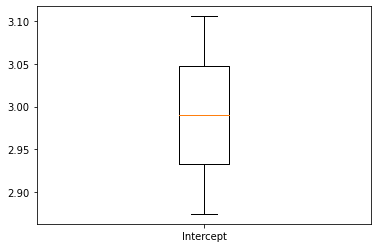

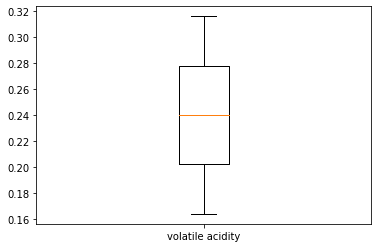

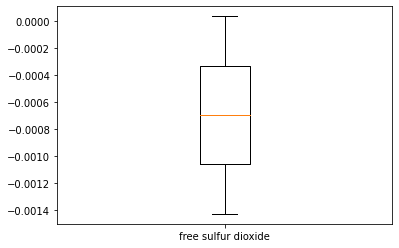

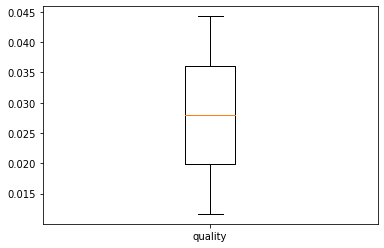

In [257]:
for i, col in enumerate(aux_vars):
    low = np.quantile(betas[:, i], 0.025, axis=0)
    high = np.quantile(betas[:, i], 0.975, axis=0)
    plt.boxplot((low, high), labels=[col])
    plt.show()